In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import*
from tensorflow.keras.layers import*
from tensorflow.keras.optimizers import*
from tensorflow.keras.callbacks import*
from tensorflow.keras.preprocessing.image import*
from tensorflow.keras import backend as k
# The typo was in the module name. Changed 'matrics' to 'metrics'
from tensorflow.keras.metrics import MeanIoU, Accuracy # Changed 'MeanIou' to 'MeanIoU' for consistency.

from sklearn.metrics import *
import numpy as np  # or from numpy import array if you prefer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


In [ ]:
gups = tf.config.experimental.list_physical_devices('GPU') # Corrected the typo from 'exprimental' to 'experimental'
if gups:
    try:
        for gpu in gups:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Step 2 Data prepration

In [ ]:
x_train=glob.glob('/content/drive/MyDrive/train/x/*.png')
y_train=glob.glob('/content/drive/MyDrive/train/y/*.png')
x_test=glob.glob('/content/drive/MyDrive/test/x/*.png')
y_test=glob.glob('/content/drive/MyDrive/test/y/*.png')

x_train.sort()
y_train.sort()
x_test.sort()
y_test.sort()

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

200
200
50
50


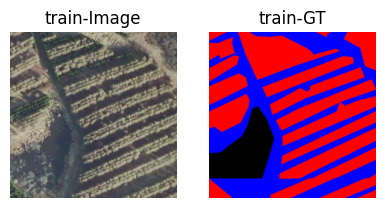

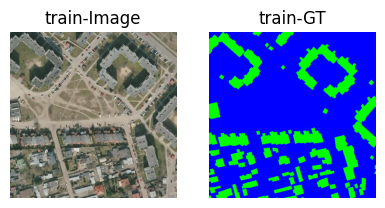

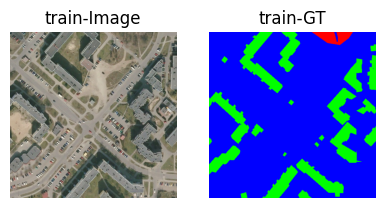

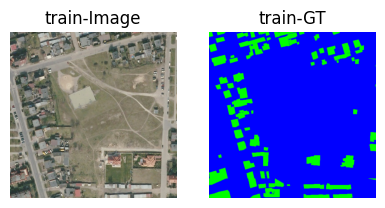

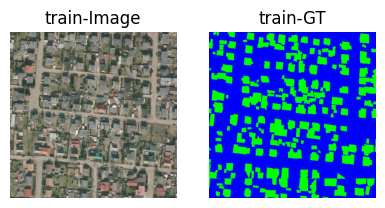

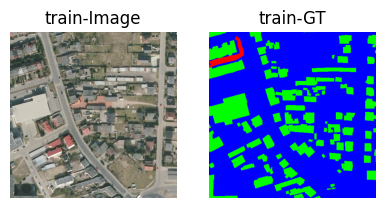

In [ ]:
for i in range(0,2):
  for j in range(0,3):
    plt.figure(figsize=(15,15))
    plt.subplot(1,6,((2*j)+1))
    plt.imshow(plt.imread(x_train[((3*i)+j+1)]))
    plt.axis('off')
    plt.title('train-Image')
    plt.subplot(1,6,((2*j)+2))
    plt.imshow(plt.imread(y_train[((3*i)+j+1)]))
    plt.axis('off')
    plt.title('train-GT')

preprocessing , create color class, one hot encoding

In [ ]:
color_dict={
    0:[0,0,0],
    1:[0,0,255],
    2:[0,255,0],
    3:[255,255,0]
}

def rgb_to_onehot(rgb_arr, color_dict=color_dict):
  num_classes = len(color_dict)
  shape = rgb_arr.shape[:2] + (num_classes,)
  arr = np.zeros(shape, dtype=np.int8)

  # Iterate through the color dictionary's items (key-value pairs)
  for i, (cls, color) in enumerate(color_dict.items()):
    arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color, axis=1).reshape(shape[:2])

  arr = np.array(arr)
  mask = np.argmax(arr, axis=-1)
  return mask

def onehot_to_rgb(onehot,color_dict=color_dict):
  out=np.zeros(onehot.shape[:2]+(3,))
  for k in color_dict.keys():
    out[onehot==k]=color_dict[k]
  return out

def get_dataset(x_dir,y_dir):
  num_samples= len(x_dir)
  x=[]
  y=[]
  for i in range(num_samples):
    x.append(plt.imread(x_dir[i])[:,:,:-1])
    y.append(rgb_to_onehot(plt.imread(y_dir[i])[:,:,:-1]*255))

  y=np.reshape(y,(-1,512,512,1))
  return np.array(x),np.array(y)

In [ ]:
(input.reshape((-1,3)))

In [ ]:
x_train,y_train=get_dataset(x_train,y_train)
x_test,y_test=get_dataset(x_test,y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(200, 512, 512, 3)
(200, 512, 512, 1)
(50, 512, 512, 3)
(50, 512, 512, 1)


Text(0.5, 1.0, 'input')

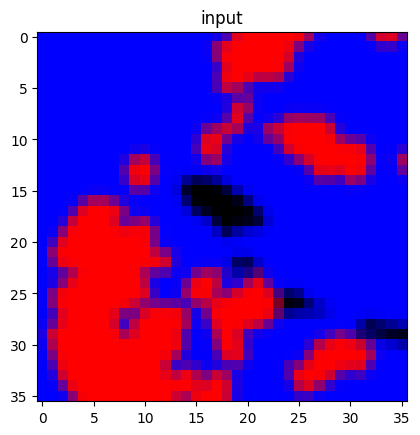

In [ ]:
sample_input=plt.imread('/content/drive/MyDrive/train/y/mask_1172.png')
input=sample_input[:,:,:-1]
from skimage.transform import resize
input=resize(input,(36,36),anti_aliasing=True)
plt.imshow(input)
plt.title('input')


In [ ]:
preprocessed=rgb_to_onehot(input*255)
np.set_printoptions(threshold=np.inf)
print(preprocessed)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 0 0 0 0 0

# **U-net Artecture**

In [ ]:
IMG_WIDTH=512
IMG_HEIGHT=512
IMG_CHANNELS=3
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
inputs=Input((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
from tensorflow.keras.models import Model
#encoder module
c1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
c1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1=MaxPooling2D((2,2))(c1)

c2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2=MaxPooling2D((2,2))(c2)

c3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=MaxPooling2D((2,2))(c3)

c4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4=Dropout(0.2)(c4)
c4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4=MaxPooling2D(pool_size=(2,2))(c4)

c5=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5=Dropout(0.3)(c5)
c5=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)

#decoder module
u6=Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
u6=concatenate([u6,c4])
c6=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6=Dropout(0.2)(c6)
c6=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

u7=Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7=concatenate([u7,c3])
c7=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

u8=Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8=concatenate([u8,c2])
c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

u9=Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9=concatenate([u9,c1],axis=3)
c9=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

outputs=Conv2D(4,(1,1),activation='softmax')(c9)

model=Model(inputs=[inputs],outputs=[outputs])


In [ ]:
#compiling and training
from tensorflow.keras.optimizers import Adam
opt=Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 512, 512, 16)   │            448 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 512, 512, 16)   │          2,320 │ conv2d_57[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 256, 256, 16)   │              0 │ conv2d_58[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 256, 256, 32)   │          4,640 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ conv2d_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 128, 128, 32)   │              0 │ conv2d_60[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_61[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 64, 64, 64)     │              0 │ conv2d_62[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_63[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 32, 32, 128)    │              0 │ conv2d_64[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 32, 32, 256)    │              0 │ conv2d_65[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ dropout_10[0][0]       │
├──────────────────────

 Total params: 1,941,156 (7.40 MB)

 Trainable params: 1,941,156 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train model
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
# Remove 'save_format='h5'' since it's not supported in older versions.
# The model will be saved in the default format (likely HDF5).
model_checkpoint=ModelCheckpoint('unet_1.keras',monitor='loss',save_best_only=True)
callback=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3,restore_best_weights=True)
history=model.fit(x_train,y_train,epochs=10,batch_size=16,callbacks=[model_checkpoint,callback])

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 623s 48s/step - accuracy: 0.5812 - loss: 1.2624
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 709s 50s/step - accuracy: 0.5854 - loss: 1.1919
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 630s 46s/step - accuracy: 0.6052 - loss: 1.1164
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 627s 46s/step - accuracy: 0.6032 - loss: 1.0572
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 608s 45s/step - accuracy: 0.6044 - loss: 0.9955
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 612s 44s/step - accuracy: 0.5859 - loss: 0.9791
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 624s 44s/step - accuracy: 0.6077 - loss: 0.9367
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 624s 44s/step - accuracy: 0.5952 - loss: 0.9279
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 624s 45s/step - accuracy: 0.6089 - loss: 0.8822
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 621s 45s/step - accuracy: 0.6101 - loss: 0.8511


In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# **Model predection**

In [ ]:
y_pred=model.predict(x_test)


In [ ]:
#sample image
i=41
test_img=model.predict(x_test[i,:,:,:].reshape(1,512,512,3))
test_img=np.argmax(test_img,axis=3)

test_img=onehot_to_rgb(test_img.reshape(512,512))
fig=plt.figure()
fig.figsize=(30,30)

ax=fig.add_subplot(1,3,1)
ax.imshow(x_test[i,:,:,:])
plt.axis('off')
ax.set_title('input image')

ax=fig.add_subplot(1,3,2)
ax.imshow((onehot_to_rgb(y_test[i,:,:,:].reshape((512,512))))/255)
plt.axis('off')
ax.set_title('GT')

ax=fig.add_subplot(1,3,3)
ax.imshow(test_img/255)
plt.axis('off')
ax.set_title('prediction')
